In [24]:
from numba import njit,jit,cuda

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

class Point:
    def __init__(self,x,y, mass=1,vx=0,vy=0, acc_x=0, acc_y=0):
        self.x = x
        self.y = y
        self.mass = mass
        self.vx = vx
        self.vy = vy
        self.acc_x = acc_x
        self.acc_y = acc_y
        
class Rectangle:
    def __init__(self,x,y,w,h):
        # x,y = center of the Rectangle
        # w = edge to edge horizontal distance
        # h = edge to edge vertical distance
        self.x = x
        self.y = y
        self.w = w
        self.h = h
        self.west_edge, self.east_edge = x - w/2, x + w/2
        self.north_edge, self.south_edge = y-h/2, y+h/2

    def contains(self,point):
        return (point.x >= self.west_edge and point.x <= self.east_edge and
        point.y >= self.north_edge and point.y <= self.south_edge)

    def intersects(self,other):
        """Does the other Rectangle object intersect with this one?"""
        return not (other.west_edge > self.east_edge or
                    other.east_edge < self.west_edge or
                    other.north_edge > self.south_edge or
                    other.south_edge < self.north_edge)

    def show(self, axis,color='black'):
        #axis.add_patch(patches.Rectangle((self.x-self.w,self.y-self.h),self.w*2,self.h*2,fill=False))
        x1, y1 = self.west_edge,self.north_edge
        x2, y2 = self.east_edge, self.south_edge
        axis.plot([x1,x2,x2,x1,x1],[y1,y1,y2,y2,y1], c='black', lw=1)
        #axis.add_patch(patches.Rectangle((self.west_edge,self.south_edge),
        #(self.east_edge-self.west_edge),
        #(self.north_edge-self.south_edge),fill=False,color=color))
class Quadtree:

    def __init__(self,boundary,n = 1):

        self.boundary = boundary

        # choosing capacity(n) = 1, i.e. if particle number crosses 1 than sub-divide
        # When do i choose that i need to sub-divide
        self.capacity = n

        # Keep track of points:
        self.points = []

        self.divided = False
        self.Mass = 0
        self.CenterOfMass_x = 0
        self.CenterOfMass_y = 0

    def subdivide(self):

        x = self.boundary.x
        y = self.boundary.y
        w = self.boundary.w/2
        h = self.boundary.h/2

        ne = Rectangle(x + w/2,y - h/2, w,h)
        self.northeast = Quadtree(ne,self.capacity);
        nw = Rectangle(x - w/2,y - h/2, w,h)
        self.northwest = Quadtree(nw,self.capacity);
        se = Rectangle(x + w/2,y + h/2, w,h)
        self.southeast = Quadtree(se,self.capacity);
        sw = Rectangle(x - w/2,y + h/2, w,h)
        self.southwest = Quadtree(sw,self.capacity);

        self.divided = True
        
    
    def insert(self,point):

        # If the point isn't in the boundary then stop!
        if self.boundary.contains(point) != True:
            return False
        
        # update com
        #self.updateCOM(point)
        
        # Check if the number of points exceed the capacity
        if len(self.points) < self.capacity:
            # if the point does not exceed then add the point,
            # to the list of points in the boundary
            self.points.append(point)
            return True
        # If the number of points exceed the given capacity then
        # subdivide the rectangular boundary into four parts

        # subdivide boundary
        if not self.divided:
            self.subdivide()
        
        # update the center of mass

        
        return (self.northeast.insert(point) or
        self.northwest.insert(point) or
        self.southeast.insert(point) or
        self.southwest.insert(point))    
    
    
    def compute_mass_distribution(self):
        
        if len(self) == 1:
            ##print("1 point => COM as point positions")
            ##print(self.points)
            self.CenterOfMass_x = self.points[0].x*self.points[0].mass
            self.CenterOfMass_y = self.points[0].y*self.points[0].mass
            self.Mass = self.points[0].mass
            
        elif len(self) == 0:
            # change the quadrant mass to 1
            self.Mass = 1
            self.CenterOfMass_x = 0
            self.CenterOfMass_y = 0
            
        else:
            if self.divided:
                
                #print(f'self.divided = {self.divided}')
                # Compute the center of mass based on the masses
                # of all child quadrants and the center of mass as
                # the center of mass of the child quadrants weights with their mass
                self.northeast.compute_mass_distribution()
                self.northwest.compute_mass_distribution()
                self.southeast.compute_mass_distribution()
                self.southwest.compute_mass_distribution()

                self.Mass = self.northeast.Mass + self.northwest.Mass + self.southeast.Mass + self.southwest.Mass
                
                self.CenterOfMass_x = (self.northeast.CenterOfMass_x+
                                       self.northwest.CenterOfMass_x+
                                       self.southeast.CenterOfMass_x+
                                       self.southwest.CenterOfMass_x)
                
                self.CenterOfMass_y = (self.northeast.CenterOfMass_y+
                                       self.northwest.CenterOfMass_y+
                                       self.southeast.CenterOfMass_y+
                                       self.southwest.CenterOfMass_y)
    
    def calculate_force(self, point,G,theta_):
        """
        Call this function for each particle in each time step.
        for example:
            for particle in num_of_particles:
                calculate_force(particle, G, theta)"""
        acc_x = 0
        acc_y = 0
        if len(self) == 1:
            if point.x != self.points[0].x and point.y != self.points[0].y:
                x_dist = -self.points[0].x + point.x
                y_dist = -self.points[0].y + point.y
                Rsq = x_dist**2 + y_dist**2

                a = G*self.points[0].mass/Rsq
                acc_x = a * x_dist/np.sqrt(Rsq)
                acc_y = a * y_dist/np.sqrt(Rsq)
                
        elif len(self) == 0:
            pass
        else:
            x_dist = self.CenterOfMass_x/self.Mass - point.x
            y_dist = self.CenterOfMass_y/self.Mass - point.y
            d = np.sqrt(x_dist**2 + y_dist**2)
            s = self.boundary.w
            #print(f"s/d = {s/d} and theta = {theta_}")
            if s/d < theta_:
                #print(f"number of points = {len(self)}")
                a = G*self.Mass/d**2
                acc_x += a * x_dist/d
                acc_y += a * y_dist/d
            else:

                #print(f'this is divided and its width was {self.boundary.w}')
                # Compute force on child node
                _x, _y = self.northwest.calculate_force(point,G, theta_)
                acc_x += _x
                acc_y += _y
                _x, _y = self.northeast.calculate_force(point,G, theta_)
                acc_x += _x
                acc_y += _y
                _x, _y = self.southwest.calculate_force(point,G, theta_)
                acc_x += _x
                acc_y += _y
                _x, _y = self.southeast.calculate_force(point,G, theta_)
                acc_x += _x
                acc_y += _y
        return acc_x, acc_y

                
        

    def __len__(self):
        """Return the number of points in the quadtree."""

        npoints = len(self.points)
        if self.divided:
            npoints += len(self.northeast)+len(self.northwest)+len(self.southeast)+len(self.southwest)
        return npoints
    
    def check_collision(self):
        # check if self.divided
        # check the distance
        # less than prob than merge
        print(f'Number of points:{len(self)}')
        points = []
        
        if self.divided:
            pass
    def get_points(self):
        n = 0
        #if len
    
    def step(self,all_points,dt,G,theta_):
        """This function updates the position of the point w.r.t
        all other particles
        all_points: list of all Point objects"""
        all_points_updated = []
        self.compute_mass_distribution()
        for point in all_points:
            #print(f"calculating forces on point with x = {point.x}")
            point.x = point.x + point.vx*dt
            point.y = point.y + point.vy*dt
            point.acc_x,point.acc_y = self.calculate_force(point,G,theta_)
            point.vx = point.vx + point.acc_x*dt
            point.vy = point.vy + point.acc_y*dt
            
            all_points_updated.append(point)
        return all_points_updated


    def show(self,axis):
        self.boundary.show(axis)
        if self.divided:
            self.northeast.show(axis)
            self.northwest.show(axis)
            self.southeast.show(axis)
            self.southwest.show(axis)


In [45]:
from IPython.display import clear_output

In [46]:
def get_cart_coords(r,theta):
    """returns x,y"""
    return r*np.cos(np.deg2rad(theta)), r*np.sin(np.deg2rad(theta))

def get_cart_coords_vel(rv, thetav, r, theta):
    vx = rv*np.cos(np.deg2rad(theta)) - r*np.sin(np.deg2rad(theta))*thetav
    vy = rv*np.sin(np.deg2rad(theta)) + r*np.cos(np.deg2rad(theta))*thetav
    return vx, vy


KeyboardInterrupt: 

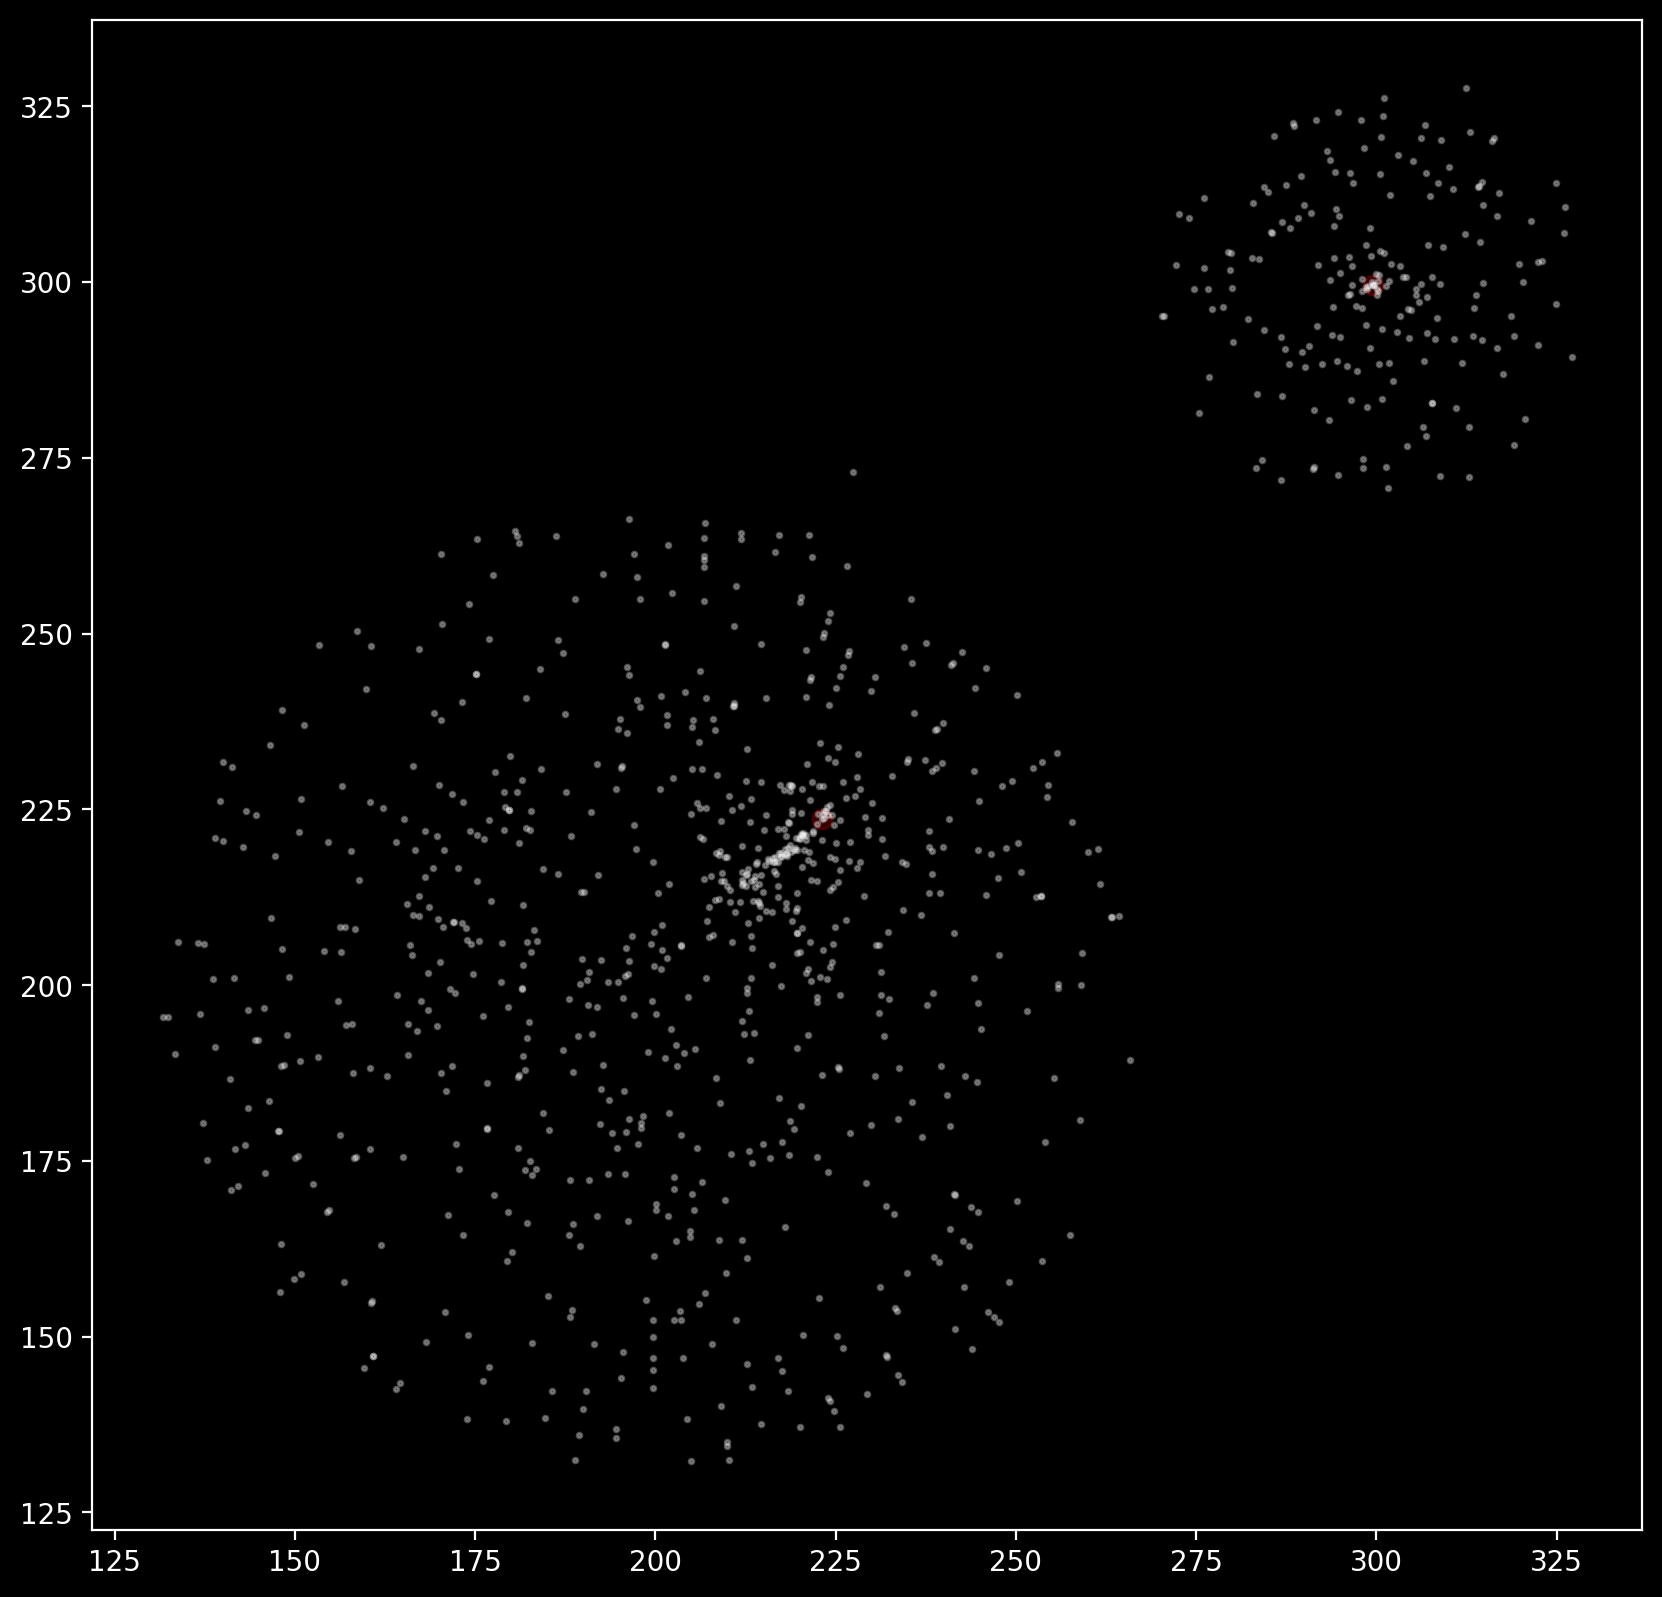

In [61]:
plt.style.use('dark_background')
points = []

# specs of Rectangle (the main boundary):
width = 400
height = 400
center_x = 200
center_y = 200
boundary = Rectangle(center_x,center_y,width,height)

# black hole at center

points.append(Point(center_x,center_y, mass= 50e15,vx=0,vy=0))

# rogue: black hole:
rogue_x = center_x + 100
rogue_y = center_y + 100
rogue_vx = 0
rogue_vy = 0
points.append(Point(rogue_x,rogue_y,mass=3e13,vx=rogue_vx,vy=rogue_vy))

#stars for rogue black hole
for i in range(200):
    r = np.random.uniform(0,30)
    theta = i*360/50
    x,y = get_cart_coords(r, theta)
    
    rv = np.random.uniform(-10,0)
    thetav = np.random.normal(loc=-40,scale=3) if abs(x) <30 and abs(y) <30 else np.random.normal(-10,2)
    vx,vy = get_cart_coords_vel(rv,-10,r,theta)
    
    mass = np.random.randint(400,10e2)
    points.append(Point(x+rogue_x,y+rogue_y,mass=mass,vx=vx+rogue_vx,vy=vy+rogue_vy))


# stars for center black hole
for i in range(800):
    r = np.random.uniform(1,70)
    theta = i*360/80
    x,y = get_cart_coords(r, theta)
    
    rv = np.random.uniform(-100,-90)
    thetav =-35 if abs(x) <30 and abs(y) <30 else -10
    #thetav = 0
    #rv= 0
    vx,vy = get_cart_coords_vel(rv,thetav,r,theta)
    
    mass = np.random.randint(400,15e2)
    points.append(Point(x+center_x,y+center_y,mass=mass,vx=vx,vy=vy))

for time in range(500):
    plt.figure(figsize=(10,10),dpi=200)
    ps = []
    qt = Quadtree(boundary)
    for p,n in zip(points,range(len(points))):
        if n == 0 or n == 1:
            plt.scatter(p.x,p.y, c='red',s=50,alpha=0.2)
            
        ps.append([p.x,p.y])
        qt.insert(p)
    ps = np.array(ps)
    plt.scatter(ps[:,0],ps[:,1],s=3,alpha=0.3,c='white')
    points = qt.step(points,dt=0.001, G=6.67e1,theta_=100.5)
    
    plt.xlim(0, 400)
    plt.ylim(0, 400)
    plt.savefig("C:/Users/astro/Documents/GitHub/Orbital-simulations/animation_dump/"+str(time)+'.png')
    plt.show()
    print(f"frame: {time}/500")    
    clear_output(wait=True)




In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle as rect
import utils
fig, ax = plt.subplots(figsize=(5,5))

# specs of Rectangle:
width = 400
height = 400
center_x = 200
center_y = 200
boundary = Rectangle(center_x,center_y,width,height)
qt = Quadtree(boundary)

for i in range(500):
    x = np.random.randint(0,400)
    y = np.random.randint(0,400)
    mass = np.random.randint(3,500)
    p = Point(x,y,mass)
    ax.scatter(p.x,p.y,s=1,c='black')
    qt.insert(p)

# give me points in this region
region = Rectangle(100,100,68,50)
found_points = []
qt.query(region,found_points)
ax.scatter([p.x for p in found_points],[p.y for p in found_points],
facecolors='none', edgecolors='r',s=32)
region.show(ax,color='red')
ax.set_xlim(center_x-width/2,center_x+width/2)
ax.set_ylim(center_y-height/2,center_y+height/2)

qt.show(ax)
plt.show()


In [ ]:
np.random.randint(0,10)